In this project, I analyse the Ame's housing dataset to try to predict prices of housing in Boston. The goal is to leverage powerful Machine Learning techniques to reach the top 5% on the Kaggle competition.
<br><br>

Here I also aim to show the various steps leading up to the final predicitons. Of course, notebooks are linear and an idealisation of the highly iterative process involved in understanding the data, building pipelines, trying models, troubleshooting, but I will try to give a sense of the whole approach.
<br><br>

Let's jump right into it!


Just before, a special acknowledgment for the people who write notebooks that inspired me on kaggle:

<br><br>


# 0. Import libraries

In [17]:
import json
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#ML
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

import scipy as sp

## dont want warnings for final version
#import warnings
#warnings.filterwarnings("ignore")



# 1. load the data set

First we load the data and perform a few initial processing steps

In [2]:
# import data

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
print(train.shape)
print(test.shape)

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# remove Id col for further preprocessing
train_noid=train.drop('Id',axis=1)
test_noid=test.drop('Id',axis=1)

print(train_noid.shape)
print(test_noid.shape)

# lets also combine train and test for preprocessing
train_nodv=train_noid.drop(columns=["SalePrice"])#remove dv to concatenate
# put dv aside
y=train["SalePrice"]
y_log=np.log(y)
# add info about the original set to which data belongs
tmp_train=train_nodv.copy()
tmp_train["set_id"]="train"
tmp_test=test_noid.copy()
tmp_test["set_id"]="test"
all_data=pd.concat([tmp_train,tmp_test])

all_data.shape


(1460, 81)
(1459, 80)
(1460, 80)
(1459, 79)


(2919, 80)

# 2. First look at the data

The first step is to get a bird eye view of our data. It may be quite complex with many features and complicated relationhips. Let's get genral information from it before diving into the details.

First off, let's see how big is the data we have to deal with

In [4]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


80 features to take into account. That's quite a lot! 
<br>Let's further check our different types of variables to get a bird eye view on our data.

In [7]:
# Get the data types of each column
data_types = train.dtypes

# Count the number of features for each data type
data_type_counts = data_types.value_counts()

print("\nNumber of features of each data type:")
print(data_type_counts)


Number of features of each data type:
object     43
int64      35
float64     3
Name: count, dtype: int64


Almost half are categorical! We'll have to take this into account for further processing and exploration.

# 3. handling missing values

Let's see if we have some missing values.

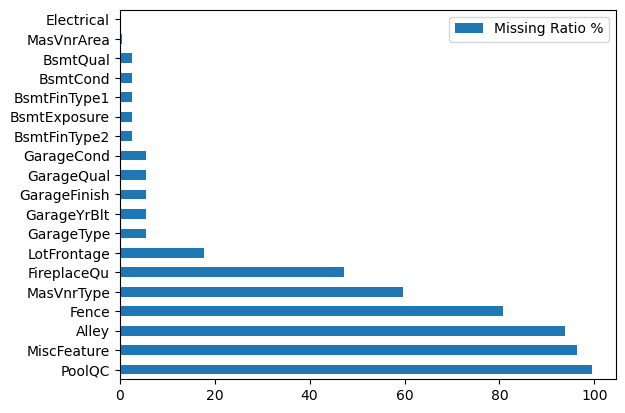

In [9]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')

plot_nas(train)

Some features miss a lot of values. Something that can catch our attention is that various features related to Garages miss exactly the same number of values. Looking at the data description, we see that "na" actually means no garage. And the same happens for other features such as Pool Quality, Fence etc...

<br><br>
We are kinda lucky, our dataset looks to of better quality than the plot above suggests. We can fill most of the nas by replacing by "none" or similar.

In [10]:
def fill_false_nas(df: pd.DataFrame):
    """a lot of nas are actually values representing the absence
    of a feature. We fill these false nas with correct values"""
    #avoid modifying the orginal dataframe
    tmp=df.copy()
    tmp["PoolQC"] = tmp["PoolQC"].fillna("No_Pool")
    
    tmp["MiscFeature"] = tmp["MiscFeature"].fillna("None")
    tmp["Alley"] = tmp["Alley"].fillna("None")
    tmp["Fence"] = tmp["Fence"].fillna("None")
    tmp["MasVnrType"] = tmp["MasVnrType"].fillna("None")
    tmp["MasVnrArea"] = tmp["MasVnrArea"].fillna(0)#0 surface when non masvnr
    
    tmp["FireplaceQu"] = tmp["FireplaceQu"].fillna("None")
    # categorical garage related vars have NA for no garage. 0 in numerical vars
    tmp["GarageType"] = tmp["GarageType"].fillna("None")
    tmp["GarageFinish"] = tmp["GarageFinish"].fillna("None")
    tmp["GarageQual"] = tmp["GarageQual"].fillna("None")
    tmp["GarageCond"] = tmp["GarageCond"].fillna("None")
    # for numerical values related to house without garage, some nas can be replaced by 0.
    tmp["GarageArea"] = tmp["GarageArea"].fillna(0)
    tmp["GarageYrBlt"] = tmp["GarageYrBlt"].fillna(0)
    tmp["GarageCars"] = tmp["GarageCars"].fillna(0)
    
    # basement
    tmp["BsmtQual"] = tmp["BsmtQual"].fillna("None")
    tmp["BsmtCond"] = tmp["BsmtCond"].fillna("None")
    tmp["BsmtExposure"] = tmp["BsmtExposure"].fillna("None")
    tmp["BsmtFinType1"] = tmp["BsmtFinType1"].fillna("None")
    tmp["BsmtFinType2"] = tmp["BsmtFinType2"].fillna("None")
    tmp["BsmtCond"] = tmp["BsmtCond"].fillna("None")
    
    # can assume nas are typical from documentation
    tmp["Functional"] = tmp["Functional"].fillna("Typ")
    
    # numerical columns with nas related to missing bsmt. fill with 0s
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        tmp[col] = tmp[col].fillna(0)
    # utils is not informative almost 100% same value  
    tmp=tmp.drop(['Utilities'],axis=1)
    return tmp


all_data=fill_false_nas(all_data)

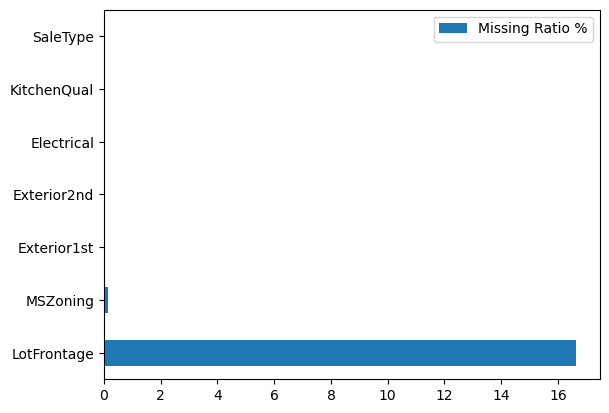

In [11]:
plot_nas(all_data)

Cool! almost no nas left!

for the real missing values that remain, several methods could be applied. Removing the whole row, filling with the mean or mode, or using more advanced machine learning methods to infer the most likely missing values. For example, we could try to use KNN to fill the missing value with the mean of the most similar instances. Here we go simple.

<br><br>
For the features with very few missing values, we will just take the mode, i.e. the most common category for categorical variables.

<br><br> For Lot Frontage, we will try something a bit more thoughtful. Lot Frontage is the length of the property touching the street. We can assume that this value is similar in different neighborhoods, so we will fill this value with the median of each neighborhood. The mean may be distorted by atypical housing with extreme values, so better to go for the median.


In [12]:
def fill_true_nas(df: pd.DataFrame):
    """some features have actual missing values that does not seem to be
    accurately and easily inferred from other features. We use various methods 
    to fill these nas"""
    
    tmp=df.copy() # avoid modifying the original df
    # we replace these nas with the most common value
    mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
    for col in mode_col:
        tmp[col] = tmp[col].fillna(tmp[col].mode()[0])
    #same filling with mode for this feature
    tmp["MSZoning"]=tmp["MSZoning"].fillna(tmp["MSZoning"].mode()[0])
    #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    tmp["LotFrontage"] = tmp.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    return tmp

all_data=fill_true_nas(all_data)

In [13]:
plot_nas(all_data)

No NAs found


Done with the missing values!

Now we'd like to get preliminary insights on which features best explain housing prices. Correlation is the go to method. But here, as we have a mix of categorical and numerical features, it is limited as it won't capture associations of categorical variables with price.

So, let's use mutual information to quatify dependencies between variables. It tells us roughly how knowing one variable x gives information about another variable y. It typically ranges between 0 (no association) and 2 (high association), although it has no upper bound.

In [23]:
# get the training set back from processed data
X=all_data[all_data["set_id"]=="train"].copy()

#do label encoding on categorical variable to perform mi ana
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == "int64"

# extract colnames of discrete features for mi computation
discrete_features = tmp.select_dtypes(include='object').columns.tolist()
print(discrete_features)



# make a boolean mask to indicate if col is categorical (True) or not (False)
# to feed to mi function
discrete_features_bool=[]
for col in X.columns.tolist():
    if col in discrete_features:
        discrete_features_bool.append(True)
    else:
        discrete_features_bool.append(False)


['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'set_id']


In [26]:
def make_mi_scores(X, y, discrete_features):
    # run mutual info regression
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # turn it to series
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # sort it
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features_bool)
mi_scores[::3]  # show a few few

OverallQual     0.557904
YearBuilt       0.370980
GarageArea      0.360444
KitchenQual     0.327497
GarageFinish    0.263264
FullBath        0.250159
GarageType      0.204740
LotFrontage     0.196034
LotArea         0.159523
OpenPorchSF     0.150311
MSZoning        0.124477
MasVnrType      0.094013
LotShape        0.087434
GarageCond      0.077819
HalfBath        0.071147
CentralAir      0.064398
PavedDrive      0.048522
KitchenAbvGr    0.039714
Condition1      0.029900
LandContour     0.024044
ExterCond       0.015669
LotConfig       0.011135
BsmtFinSF2      0.005779
MiscFeature     0.001894
Street          0.000150
PoolQC          0.000000
LandSlope       0.000000
Name: MI Scores, dtype: float64

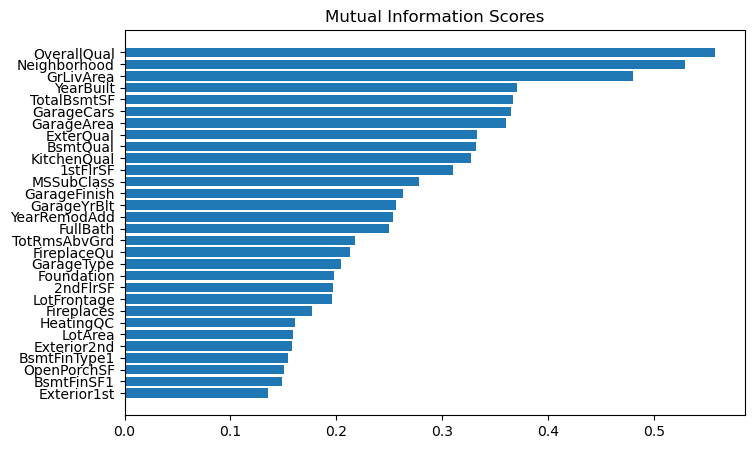

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:30])

We can see that we have an overall quality feature that contains a lot of information about housing price. The neighborhood of course is a very important factor.

<br><br>
One surprising finding is that the total surface of the basement is one of the most important predictor of the housing price! But it may hint at some issue with our high dimensional data set: multicollinearity. It is most likely highly correlated with other variables such as the the ground living area. 

<br><br>
We can guess that many variables will be highly correlated. For example, the number of cars that the garage can contain (GarageCars) and its area (GarageArea).

<br><br>
We will have to deal with that, as some machine learning models (eg linear regression) will not handle multicolinearity well.


let's take a quick look at our correlation matrix (numerical data only)

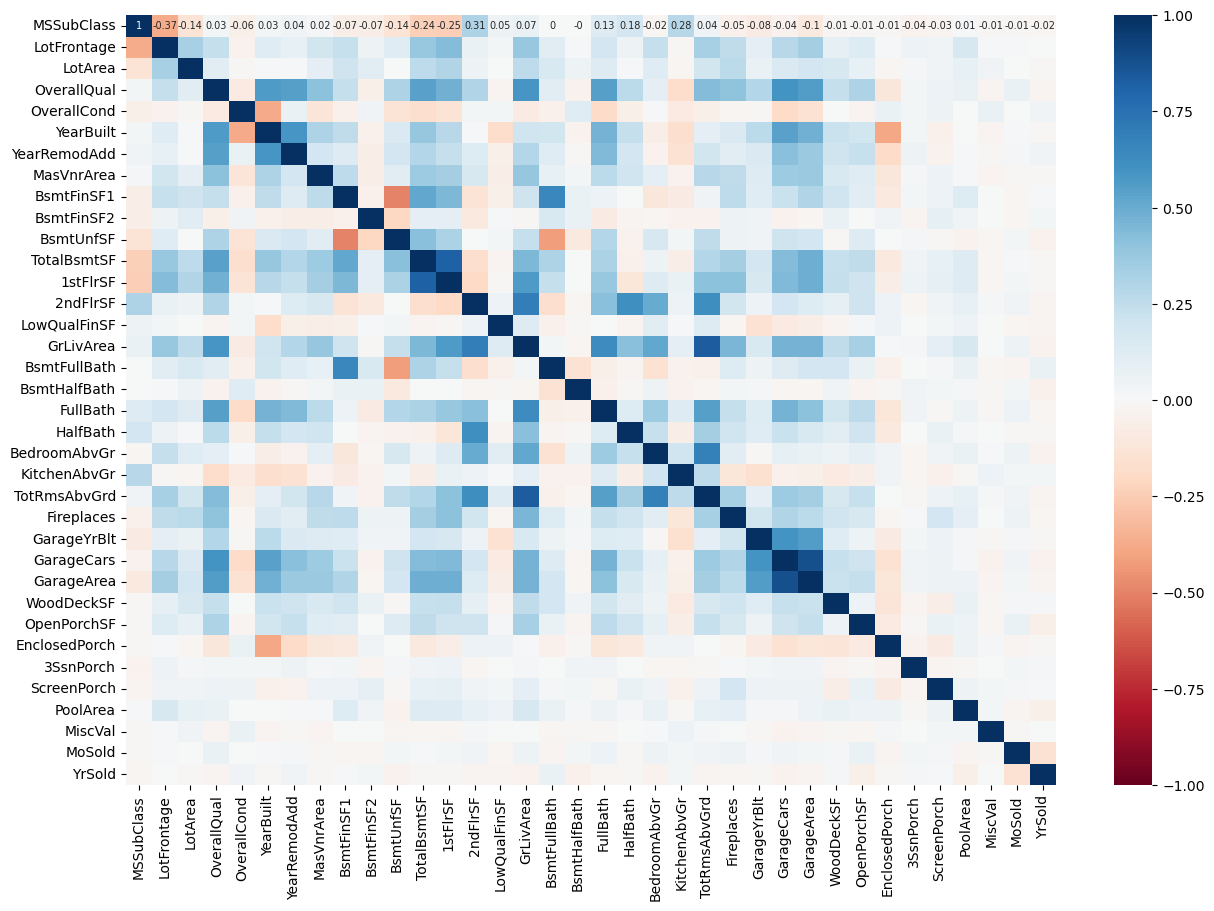

In [28]:
plt.figure(figsize=(15,10))
# extract training data
train_num=all_data[all_data["set_id"]=="train"].copy()
#keep only numerical variables
train_num=train_num.select_dtypes(include=[ 'number'])

correlations = train_num.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

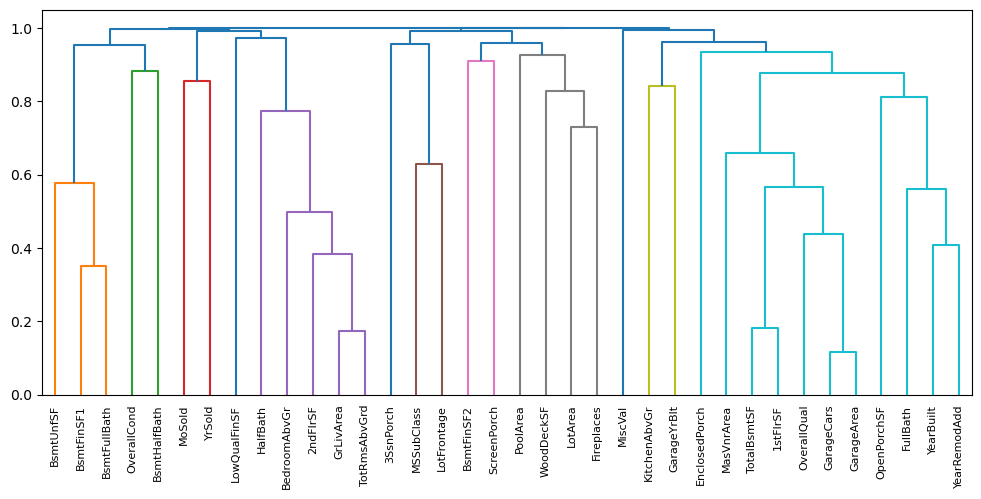

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=train_num.columns, orientation='top', 
           leaf_rotation=90,color_threshold=0.95);

In [39]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([ 8,  8, 12, 17,  2, 18, 18, 17,  1, 10,  1, 17, 17,  6,  7,  6,  1,
        3, 18,  6,  6, 15,  6, 12, 16, 17, 17, 13, 19, 20,  9, 11, 14, 21,
        4,  5], dtype=int32)

In [41]:
import numpy as np

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(train_num.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(train_num[i])
    else:
        df_to_append = pd.DataFrame(train_num[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

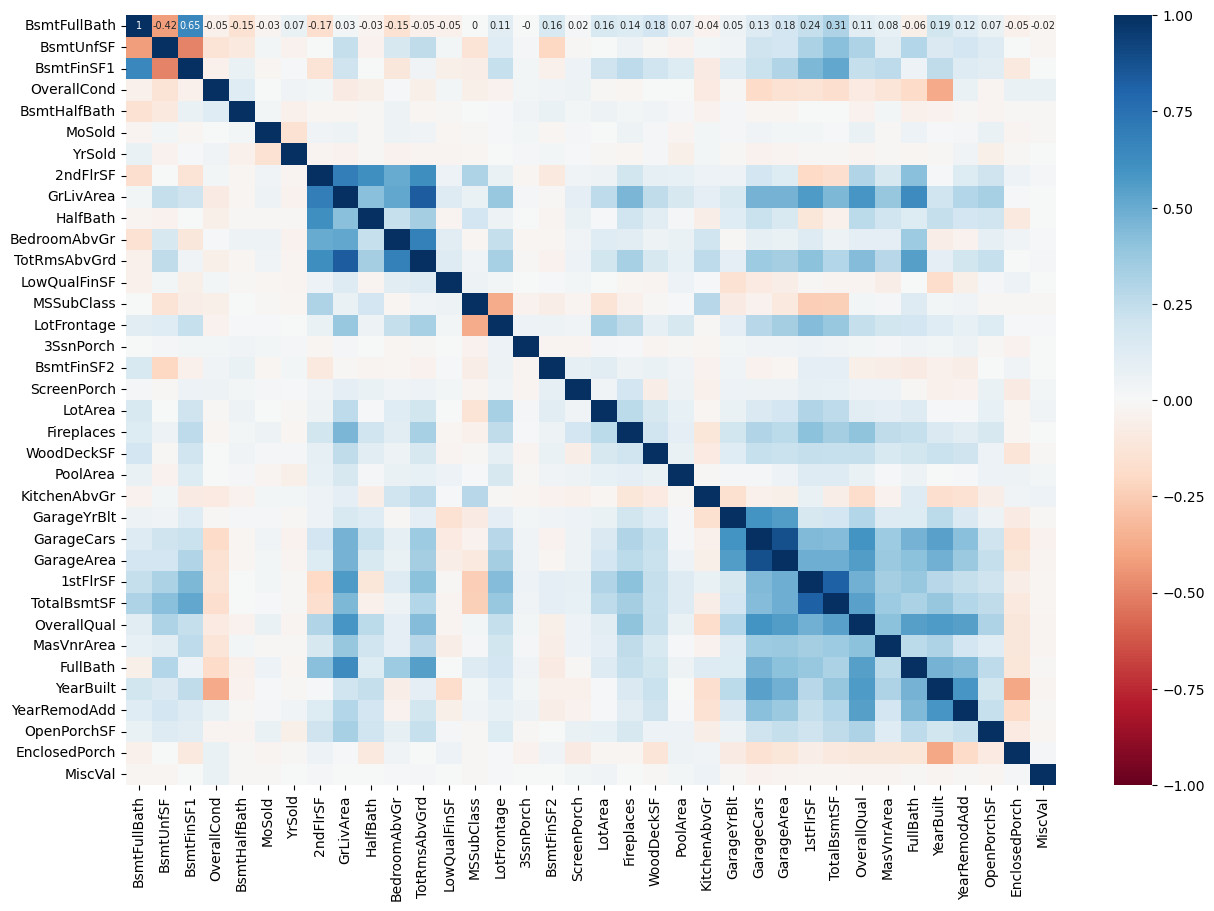

In [42]:
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

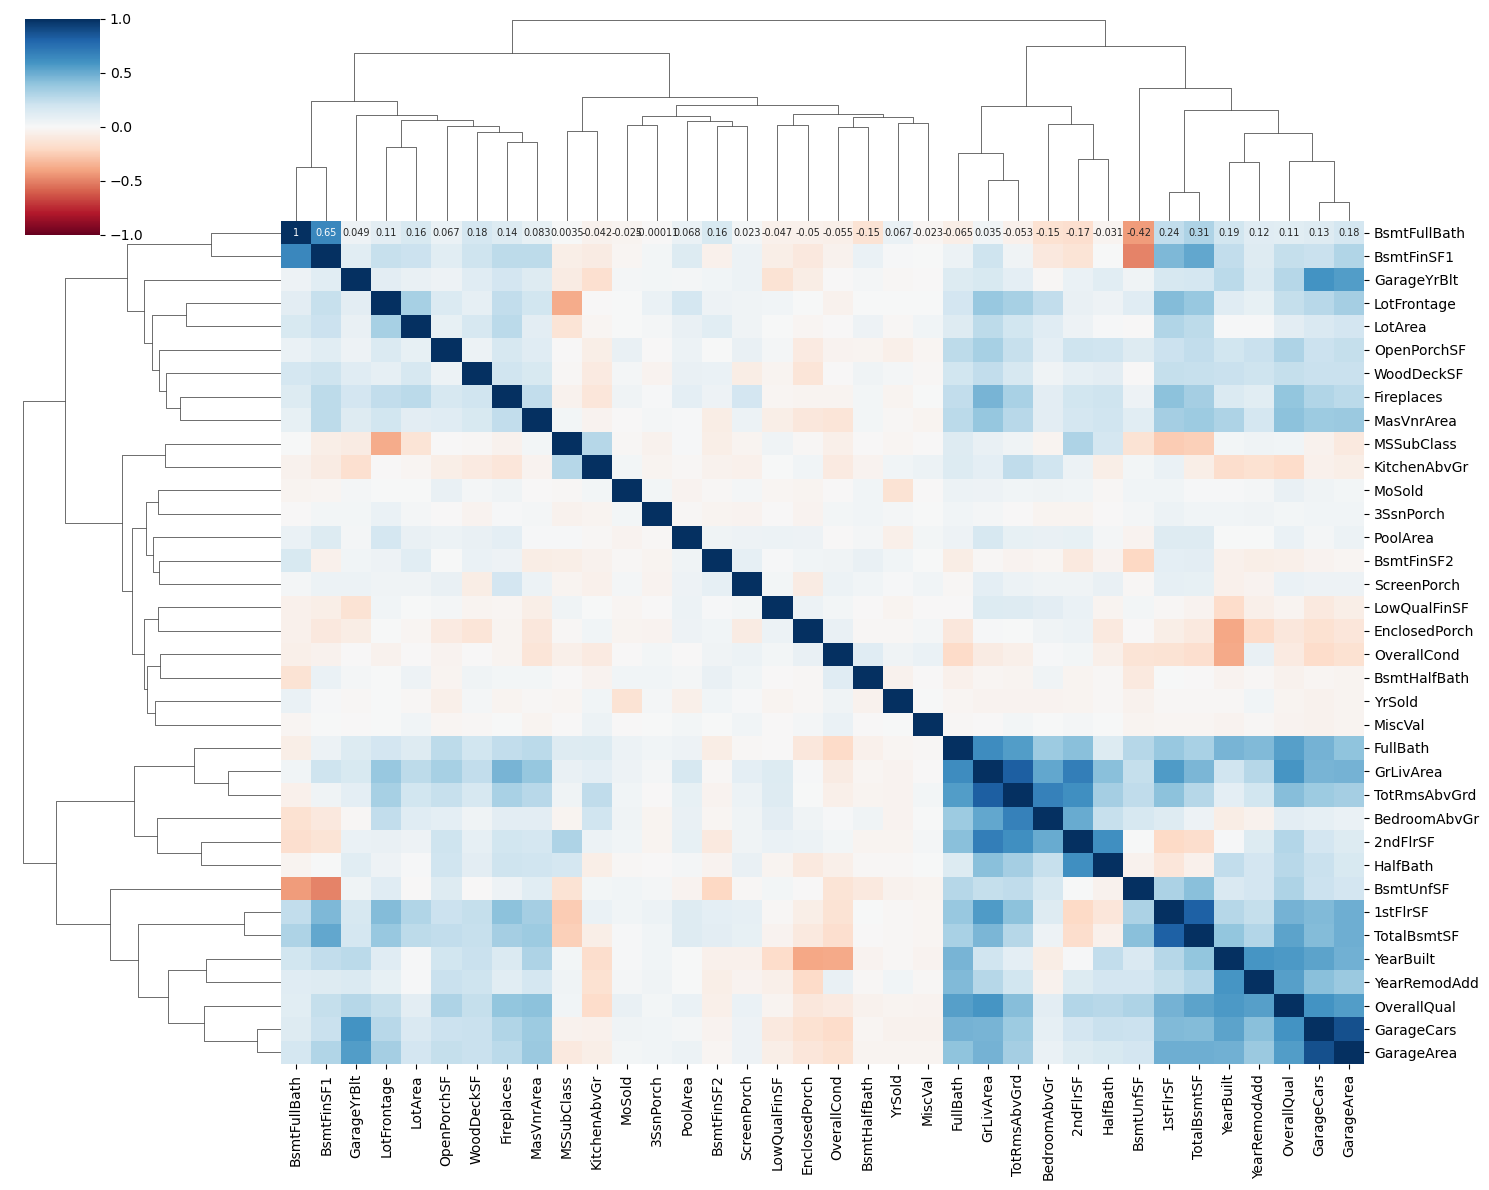

In [43]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));